In [1]:
import sys
import pandas as pd
sys.path.insert(0, "../")

from michael import janet

Hi there. Welcome to the good place.


In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

Index 258 is a good tester. Clear rotational signal, ambiguous peak mode.

In [86]:
j = janet.boot(uni, index=10)

In [87]:
j

Hi there! I'm Janet 🌵
I don't have any data or results in storage right now. Try running `janet.prepare_data()` to get started! ✨

In [88]:
j.prepare_data()

Making folder /Users/oliver hall/Research/unicorn/data/3291636963988888960/...
Found star in Sector(s) 5


/Users/Anaconda/anaconda3/lib/python3.8/site-packages/eleanor-2.0.2-py3.8.egg/eleanor/ffi.py:40: UserWarning: couldn't find pointing model
  warnings.warn("couldn't find pointing model")


No postcard object will be created for this target.


In [89]:
j.get_rotation()

### Running Simple Astropy Lomb-Scargle on Sector all on star 3291636963988888960 ###
### Completed Simple Astropy Lomb-Scargle for Sector all on star 3291636963988888960 ###
### Saved results ###


In [90]:
j

Hi there! I'm Janet 🌵

KeyError: 'pg_5'

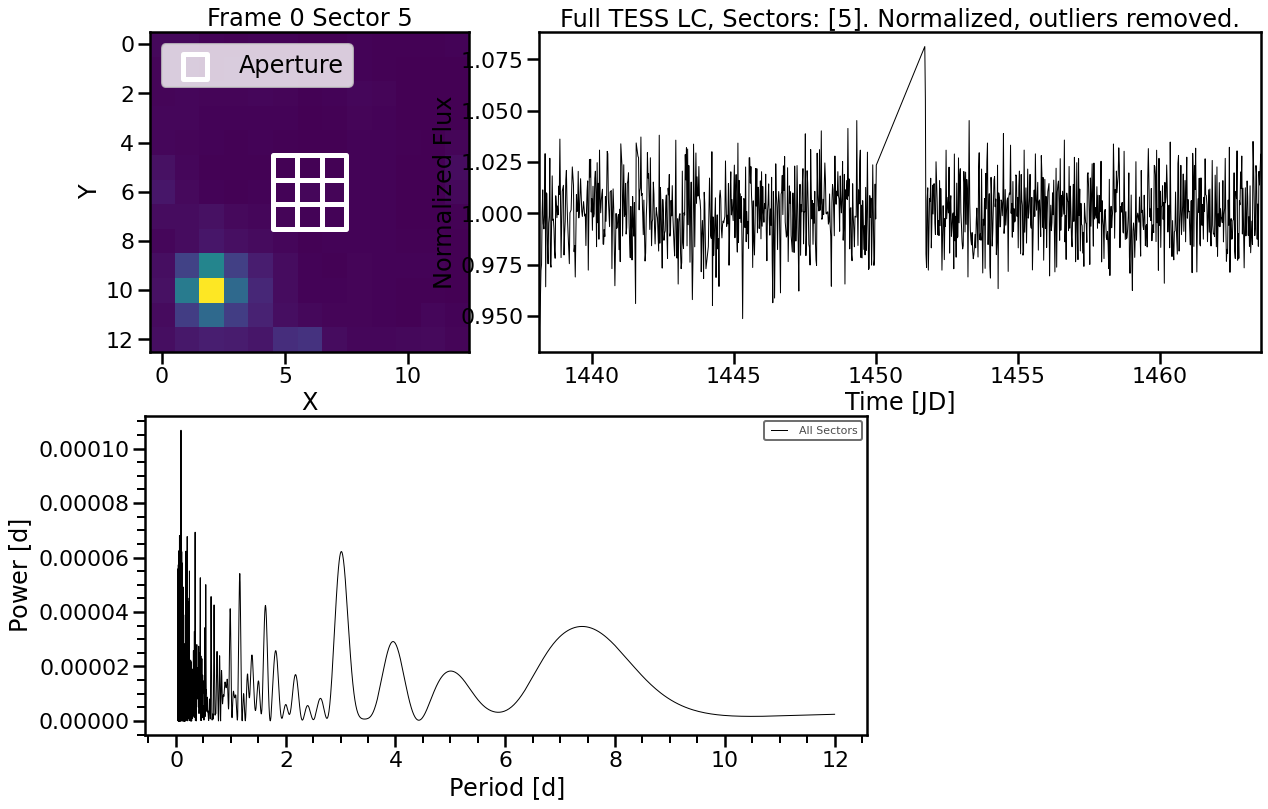

In [91]:
j.view()

### Wavelet

In [ ]:
clc = j.void['clc_all']

In [ ]:
import jazzhands

In [ ]:
t = clc.time.value
f = clc.flux.value
wt = jazzhands.WaveletTransformer(t, f)
_,_,wwz,_ = wt.auto_compute(nu_min = 1/12, nu_max = 1/0.2)

In [ ]:
import numpy as np
c = plt.contourf(wt.taus, 1/wt.nus, wwz, vmin=0, vmax=np.nanpercentile(wwz.flatten(), [99]))
plt.colorbar(c)
plt.yscale('log')

In [ ]:
d = np.sum(wwz, axis=1)
d.shape

In [ ]:
plt.plot(1/wt.nus, d)

In [ ]:
1/wt.nus[np.argmax(d)]

In [ ]:
np.argmax(d)